#### Random seed

In [8]:
import numpy as np
import pandas as pd
import torch
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(999)

### INTRODUCTION BY EXAMPLE

In [9]:
import torch
from torch_geometric.data import Data
import networkx as nx

In [10]:
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

In [11]:
from torch_geometric.utils import to_networkx

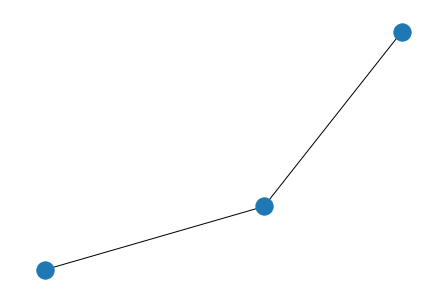

In [12]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, pos=nx.spiral_layout(G))

In [13]:
A = nx.to_numpy_matrix(G)
A

matrix([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]])

In [14]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [15]:
dataset = TUDataset(root='/tmp/IMDB', name='IMDB-BINARY', use_node_attr=True).shuffle()
data_sz = len(dataset)
x0, x1 = round(0.8*data_sz), round(0.9*data_sz)
train_set, validation_set, test_set = dataset[0:x0], dataset[x0:x1], dataset[x1:] 

In [16]:
len(train_set), len(validation_set), len(test_set)

(800, 100, 100)

In [17]:
batch_size = 32

In [18]:
train_loader = DataLoader(train_set, batch_size=batch_size)

In [19]:
def summation(batch):
    edge = 0
    node = 0
    for x, _ in enumerate(batch.y):
        edge += batch[x].edge_index.shape[1]
        node += batch[x].num_nodes
    return edge, node

In [20]:
for batch in train_loader:
    print(batch.num_graphs, summation(batch), batch)
    break

32 (5108, 628) DataBatch(edge_index=[2, 5108], y=[32], num_nodes=628, batch=[628], ptr=[33])


#### CREATING MESSAGE PASSING NETWORKS

In [21]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [22]:
class myGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)
    def reset_parameters(self):
        torch.nn.init.xavier_normal_(self.lin.weight.data)
    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, norm=norm)
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

MessagePassing (related functions)
- forward
- messsage
- propagate
- update

In [23]:
conv = myGCNConv(16, 32)

#### MEMORY-EFFICIENT AGGREGATIONS

In [24]:
from torch_sparse import matmul

In [25]:
class myGINConv(MessagePassing):
    def __init__(self, in_channels, out_channels, eps=1e-5):
        super().__init__(aggr='add')
        self.mlp = torch.nn.Linear(in_channels, out_channels)
        self.eps = eps
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.mlp.weight.data)
                
    def forward(self, x, edge_index):
        out = self.propagate(edge_index, x=x)
        return self.mlp((1+self.eps)*x + out)
    
    def message(self, x_j):
        return x_j
    
    def message_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

#### GCNConv

In [26]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout

##### SELF-DESIGNED

In [27]:
class GCNLayer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, out_channels, eps=1e-4, aggr = "add", activation_fn=None):
        super().__init__()
        assert aggr in ['add', 'mean', 'max']
        
        self.in_channels = in_channels
        self.hidden_channles = hidden_channels
        self.num_layers = num_layers
        self.out_channels = out_channels
        self.eps = eps
        self.aggr = aggr
        self.activation_fn = activation_fn
        
        if num_layers == 1:
            self.lin = torch.nn.ModuleList([Linear(in_channels, out_channels, bias=False)])
        else:
            self.lin = torch.nn.ModuleList([Linear(in_channels, hidden_channels, bias=False)])
            self.lin.extend([Linear(hidden_channels, hidden_channels, bias=False) for x in range(num_layers-2)])
            self.lin.extend([Linear(hidden_channels, out_channels, bias=False)])
        self.bns = torch.nn.ModuleList([BatchNorm1d(hidden_channels) for x in range(num_layers-1)])
        self.reset_parameters()
        
    def reset_parameters(self):
        for net in self.lin:
            torch.nn.init.kaiming_normal_(net.weight.data)
        for net in self.bns:
            torch.nn.init.ones_(net.weight.data)
        
    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)
    
    def update(self, inputs):
        return inputs
    
    def propagate(self, x, edge_index):
        return (1 + self.eps)*x + self.message_and_aggregate(edge_index, x)
    
    def forward(self, x, edge_index):
        out = self.propagate(x, edge_index)
        for l in range(self.num_layers):
            out = self.lin[l](out)
            if l != self.num_layers-1:
                out = self.bns[l](out)
                x = F.relu6(x)
                out = F.dropout(out, training=self.training)
        if self.activation_fn:
            out = self.activation_fn(out)
        return out

In [28]:
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):
        # TODO: Implement a function that initializes self.convs, 
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = None

        # A list of 1D batch normalization layers
        self.bns = None

        # The log softmax layer
        self.softmax = None

        ############# Your code here ############
        ## Note:
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and 
        ## 'out_channels'. For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## For more information please refer to the documentation: 
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        ## (~10 lines of code)
        self.convs = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)])
        self.convs.extend([GCNConv(hidden_dim, hidden_dim) for x in range(num_layers-2)])
        self.convs.extend([GCNConv(hidden_dim, output_dim)])
        
        self.bns = torch.nn.ModuleList([BatchNorm1d(hidden_dim) for x in range(num_layers-1)])

        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.num_layers = num_layers
        #########################################

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds
        self.reset_parameters()

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # TODO: Implement a function that takes the feature tensor x and
        # edge_index tensor adj_t and returns the output tensor as
        # shown in the figure.

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer
        ## (~7 lines of code)
        for depth, conv in enumerate(self.convs):
            x = conv(x, adj_t)
            if depth == self.num_layers - 1:
                out = x if self.return_embeds else self.softmax(x)
            else:
                x = self.bns[depth](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        #########################################
        return out

In [29]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T

dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                transform=T.ToSparseTensor())
data = dataset[0]

In [30]:
# Make the adjacency matrix to symmetric
data.adj_t = data.adj_t.to_symmetric()

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

Device: cuda:3


KeyboardInterrupt: 

In [ ]:
def train(model, data, train_idx, optimizer, loss_fn):
    # TODO: Implement a function that trains the model by 
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    ############# Your code here ############
    ## Note:
    ## 1. Zero grad the optimizer
    ## 2. Feed the data into the model
    ## 3. Slice the model output and label by train_idx
    ## 4. Feed the sliced output and label to loss_fn
    ## (~4 lines of code)
    optimizer.zero_grad()
    output = model(data.x, data.adj_t)
    loss = loss_fn(output[train_idx], data.y[train_idx].squeeze(1))
    #########################################

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    # TODO: Implement a function that tests the model by 
    # using the given split_idx and evaluator.
    model.eval()

    # The output of model on all data
    out = None

    ############# Your code here ############
    ## (~1 line of code)
    ## Note:
    ## 1. No index slicing here
    out = model(data.x, data.adj_t)
    #########################################

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-arxiv_node.csv', sep=',', index=False)


    return train_acc, valid_acc, test_acc

In [ ]:
# Please do not change the args
args = {
    'device': device,
    'num_layers': 4,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 1e-2,
    'epochs': 100,
}
args

In [ ]:
import copy
# reset the parameters to initial random value
def model_choice(model, args):
    evaluator = Evaluator(name='ogbn-arxiv')
    model.reset_parameters()

    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    loss_fn = F.nll_loss

    best_model = None
    best_valid_acc = 0

    for epoch in range(1, 1 + args["epochs"]):
        loss = train(model, data, train_idx, optimizer, loss_fn)
        result = test(model, data, split_idx, evaluator)
        train_acc, valid_acc, test_acc = result
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')
    return best_model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model1 = GCN(data.num_features, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)
best_model1 = model_choice(model1, args)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
args['epochs'] = 256
model2 = GCNLayer(
    data.num_features, 
    args['hidden_dim'], 
    args['num_layers'], 
    dataset.num_classes,
    eps=1e-2,
    activation_fn=torch.nn.LogSoftmax(dim=1)
).to(device)
best_model2 = model_choice(model2, args)

In [ ]:
torch.save(best_model1, "model1.pth")
torch.save(best_model2, "model2.pth")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
evaluator = Evaluator(name='ogbn-arxiv')
test_score1 = test(best_model1, data, split_idx, evaluator)
test_score2 = test(best_model2, data, split_idx, evaluator)

In [ ]:
scores = pd.DataFrame({
    "score": list(test_score1) + list(test_score2), 
    "model": [*(['GCN']*3), *(['Self-designed']*3)],
    "mode": [*(["train", "valid", "test"]*2)]
})

In [ ]:
scores.pivot_table(values='score', columns='mode', index='model')

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(data=scores, x='mode', y='score', hue='model')

#### Graph Perdict
- why use global_max_pool (forgot)

In [ ]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

class GCN_graph(torch.nn.Module):
    def __init__(self, hidden_dim, num_layers, out_dim, dropout):
        super(GCN_graph, self).__init__()

        self.node_encoder = AtomEncoder(hidden_dim)
        self.gnn_node = GCN(hidden_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = global_max_pool
        self.lin = Linear(hidden_dim, out_dim)
    
    def reset_parameters(self):
        self.gnn_node.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, batched_data):
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        
        embed = self.node_encoder(x)
        message = self.gnn_node(embed, edge_index)

        out = self.pool(message, batch)
        out = self.lin(out)
        
        return out

##### GAT

- remain to understand

In [1]:
import torch
import torch_scatter
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch.nn import Parameter, Linear, Dropout
import torch.nn.functional as F
from torch_geometric.utils import softmax
from torch_sparse import SparseTensor

#### FAILED TRY

In [11]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads = 5, 
            negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.head = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.node_dim = 0

        self.lin_l = Linear(in_channels, heads*out_channels)
        self.lin_r = self.lin_l

        self.att_l = Parameter(torch.randn(heads, out_channels))
        self.att_r = Parameter(torch.randn(heads, out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin_l.weight)
        torch.nn.init.xavier_uniform_(self.lin_r.weight)
        torch.nn.init.xavier_uniform_(self.att_l)
        torch.nn.init.xavier_uniform_(self.att_r)
    
    def message_and_propagate(self, edge_index, size, x, alpha):
        x_l, _ = x
        alpha_l, alpha_r = alpha
        node_dim = self.node_dim
        
        new_i = torch.cat([alpha_r[x].unsqueeze(0) for x in edge_index[1]], dim=0)
        new_j = torch.cat([alpha_l[x].unsqueeze(0) for x in edge_index[0]], dim=0)
        new_x_j = torch.cat([x_l[x].unsqueeze(0) for x in edge_index[0]], dim=0)

        alpha_ij = F.leaky_relu(new_i+new_j, negative_slope=self.negative_slope)
        alpha_ij = softmax(alpha_ij, edge_index[1])
        alpha_ij = F.dropout(alpha_ij, self.dropout)
        out = alpha_ij * new_x_j        
        out = torch_scatter.scatter(out, edge_index[1], node_dim, reduce='sum')
        return out

    def update(self, inputs):
        return inputs

    def propagate(self, edge_index, size, x, alpha):
        out = self.message_and_propagate(edge_index, size, x, alpha)
        return self.update(out)

    def forward(self, x, edge_index, size=None):
        H, C = self.head, self.out_channels
        
        x_l = self.lin_l(x).view(-1, H, C)
        x_r = self.lin_r(x).view(-1, H, C)

        alpha_l = self.att_l.unsqueeze(0) * x_l
        alpha_r = self.att_r.unsqueeze(0) * x_r

        out = self.propagate(edge_index, size, x=(x_l, x_r), alpha=(alpha_l, alpha_r))
        out = out.view(-1, H*C)
        return out



##### GAT

In [12]:
# class GAT(MessagePassing):

#     def __init__(self, in_channels, out_channels, heads = 2,
#                  negative_slope = 0.2, dropout = 0., **kwargs):
#         super(GAT, self).__init__(node_dim=0, **kwargs)
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.heads = heads
#         self.negative_slope = negative_slope
#         self.dropout = dropout

#         self.lin_l = None
#         self.lin_r = None
#         self.att_l = None
#         self.att_r = None

#         ############################################################################
#         # TODO: Your code here! 
#         # Define the layers needed for the message functions below.
#         # self.lin_l is the linear transformation that you apply to embeddings 
#         # BEFORE message passing.
#         # 
#         # Pay attention to dimensions of the linear layers, since we're using 
#         # multi-head attention.
#         # Our implementation is ~1 lines, but don't worry if you deviate from this.

#         self.lin_l = Linear(self.in_channels, self.heads*self.out_channels)
#         ############################################################################

#         self.lin_r = self.lin_l

#         ############################################################################
#         # TODO: Your code here! 
#         # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
#         # You have to deal with multi-head scenarios.
#         # Use nn.Parameter instead of nn.Linear
#         # Our implementation is ~2 lines, but don't worry if you deviate from this.

#         self.att_l = Parameter(torch.randn(heads, self.out_channels))
#         self.att_r = Parameter(torch.randn(heads, self.out_channels))
#         ############################################################################

#         self.reset_parameters()

#     def reset_parameters(self):
#         torch.nn.init.xavier_uniform_(self.lin_l.weight)
#         torch.nn.init.xavier_uniform_(self.lin_r.weight)
#         torch.nn.init.xavier_uniform_(self.att_l)
#         torch.nn.init.xavier_uniform_(self.att_r)

#     def forward(self, x, edge_index, size = None):
        
#         H, C = self.heads, self.out_channels

#         ############################################################################
#         # TODO: Your code here! 
#         # Implement message passing, as well as any pre- and post-processing (our update rule).
#         # 1. First apply linear transformation to node embeddings, and split that 
#         #    into multiple heads. We use the same representations for source and
#         #    target nodes, but apply different linear weights (W_l and W_r)
#         # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
#         # 3. Call propagate function to conduct the message passing. 
#         #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
#         #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
#         # 4. Transform the output back to the shape of [N, H * C].
#         # Our implementation is ~5 lines, but don't worry if you deviate from this.

#         x_l = self.lin_l(x).view(-1, H, C)
#         x_r = self.lin_r(x).view(-1, H, C)
        
#         alpha_l = self.att_l.unsqueeze(0) * x_l
#         alpha_r = self.att_r.unsqueeze(0) * x_r
        
#         out = self.propagate(edge_index=edge_index, size=size, x=(x_l, x_r), alpha=(alpha_l, alpha_r))
#         out = out.view(-1, H*C)
#         ############################################################################

#         return out

#     MessagePassing.message
#     def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

#         ############################################################################
#         # TODO: Your code here! 
#         # Implement your message function. Putting the attention in message 
#         # instead of in update is a little tricky.
#         # 1. Calculate the final attention weights using alpha_i and alpha_j,
#         #    and apply leaky Relu.
#         # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
#         #    torch_geometric.utils.softmax instead of the one in Pytorch.
#         # 3. Apply dropout to attention weights (alpha).
#         # 4. Multiply embeddings and attention weights. As a sanity check, the output
#         #    should be of shape [E, H, C].
#         # 5. ptr (LongTensor, optional): If given, computes the softmax based on
#         #    sorted inputs in CSR representation. You can simply pass it to softmax.
#         # Our implementation is ~4-5 lines, but don't worry if you deviate from this.

#         alpha_ij = F.leaky_relu(alpha_i+alpha_j, negative_slope=self.negative_slope)
#         if ptr is not None:
#             alpha_ij = torch_geometric.utils.softmax(alpha_ij, ptr)
#         else:
#             alpha_ij = torch_geometric.utils.softmax(alpha_ij, index)
#         alpha_ij = F.dropout(alpha_ij, self.dropout)
#         out = alpha_ij * x_j
#         ############################################################################

#         return out


#     def aggregate(self, inputs, index, dim_size = None):

#         ############################################################################
#         # TODO: Your code here! 
#         # Implement your aggregate function here.
#         # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
#         # Pay attention to "reduce" parameter is different from that in GraphSage.
#         # Our implementation is ~1 lines, but don't worry if you deviate from this.

#         node_dim = self.node_dim
#         out = torch_scatter.scatter(inputs, index, node_dim, reduce='sum')
#         ############################################################################
    
#         return out

##### GNNStack

In [18]:

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        self.heads = args.heads
        
        conv_model = GAT
        self.convs = torch.nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim, heads=self.heads))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim, heads=self.heads))

        # post-message-passing
        self.post_mp = torch.nn.Sequential(
            Linear(args.heads * hidden_dim, hidden_dim), Dropout(args.dropout), 
            Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

##### Train and Test

In [19]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [20]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)
    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


##### Go!

In [ ]:
for args in [
    {'device': 'cpu', 'model_type': 'GAT', 'dataset': 'cora', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
]:
    args = objectview(args)
for model in ['GAT']:
    args.model_type = model

    # Match the dimension.
    if model == 'GAT':
        args.heads = 3
    else:
        args.heads = 1

    if args.dataset == 'cora':
        dataset = Planetoid(root='/tmp/cora', name='Cora')
    else:
        raise NotImplementedError("Unknown dataset") 
    test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

    print("Maximum test set accuracy: {0}".format(max(test_accs)))
    print("Minimum loss: {0}".format(min(losses)))

    # Run test for our best model to save the predictions!
    test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
    print()

    plt.title(dataset.name)
    plt.plot(losses, label="training loss" + " - " + args.model_type)
    plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()


In [ ]:
2708*32

In [1]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/cora', name='Cora')

In [4]:
dataset[0].edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [6]:
dataset[0].y

tensor([3, 4, 4,  ..., 3, 3, 3])